In [1]:
import pandas as pd
import numpy as np
import xlwings as xw
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
from itertools import combinations

In [2]:
#lê os dados
df = pd.read_csv('Base.csv', index_col = 'ID').dropna(how = 'all')

produtos = df.Produto.unique()
contas = df['Account Number'].unique()
brokers = df.Broker.unique()

#cria uma coluna com o custo total da transação
df['Custo'] = df.Price * df.Qty

In [3]:
print(f'A planilha contêm {df.shape[0]} operações, feitas sobre {len(produtos)} produtos diferentes e operadas através de {len(contas)} contas e {len(brokers)} brokers.')

A planilha contêm 52623 operações, feitas sobre 53 produtos diferentes e operadas através de 4 contas e 2 brokers.


In [4]:
#cria uma pivot table e calcula o preço médio do produto
pivot = pd.pivot_table(df, index = ['Broker', 'Produto', 'Product Type'],
               columns = ['Compra/Venda'],
               aggfunc={'Custo':'sum', 'Qty': 'sum'})

pivot['preço_medio', 'B'] = pivot.Custo.B / pivot.Qty.B
pivot['preço_medio', 'S'] = pivot.Custo.S / pivot.Qty.S

pivot_precos = pivot['preço_medio']

pivot_precos

Compra/Venda                                    B              S
Broker Produto        Product Type                              
CASA A $ based NK     Future         21430.029326   21461.962025
       10yr Note      Future        121345.618358  121290.917160
       Bean Oil       Future          3081.000000            NaN
       CAC 40         Future          5215.341584            NaN
       Canadian Bonds Future           136.141974     137.360000
...                                           ...            ...
CASA B RBOB           Future         16098.000000            NaN
       Soybeans       Future          9254.000000            NaN
       Swedish Krona  Future                  NaN   10710.000000
       Toronto 60     Future           956.600000            NaN
       Wheat          Future                  NaN    4926.000000

[80 rows x 2 columns]

In [5]:
#adiciona uma coluna com a margem de lucro
pivot_lucro = pivot_precos.copy()

pivot_lucro['%N'] = (pivot_lucro['S'] - pivot_lucro['B']) * 100/pivot_lucro['S']

pivot_lucro.dropna(inplace = True)

In [6]:
#gráfico indicando os 10 ativos de maiore preço médio
def top_10(precos, lado, nome):
    fig = plt.figure(figsize = (12,10))

    top10 = precos.sort_values(by = lado, ascending = False)[:10]
    top10[lado].plot(kind='barh', colormap='Paired')
    plt.grid(True)
    plt.title(f'10 maiores preços médios de {nome}', fontsize = 20)
    plt.xlabel('Preço', fontsize = 16)
    plt.ylabel('Produto', fontsize= 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()

## CASA A

No broker CASA A, foram negociados 38 produtos a partir de 27088 operações.
Dentre as operações, 15658 foram de compra e 11430 de venda.




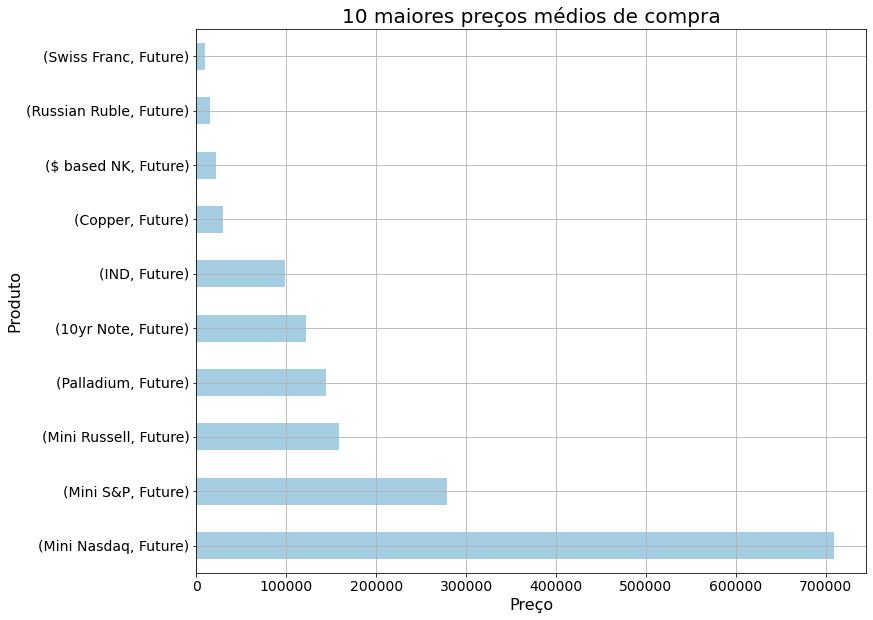

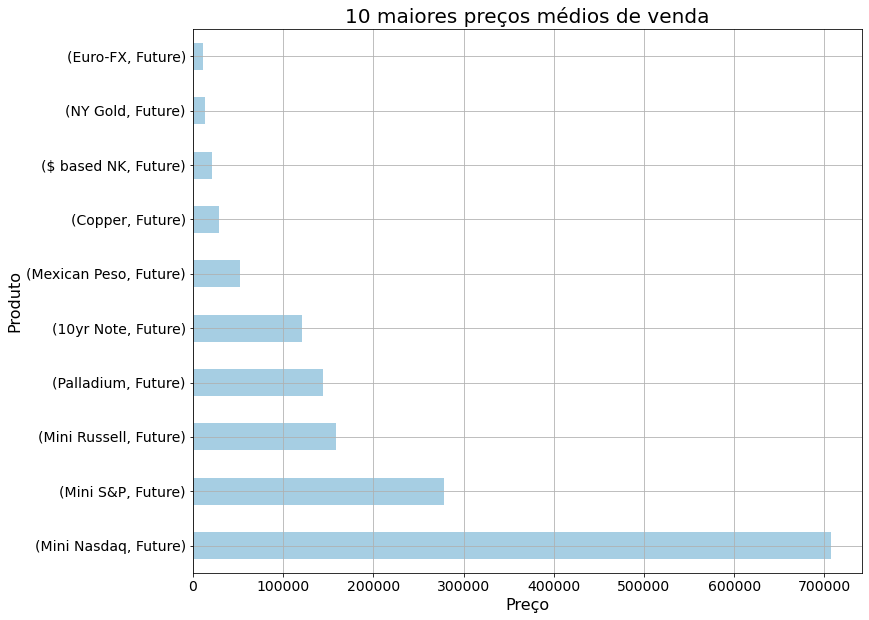

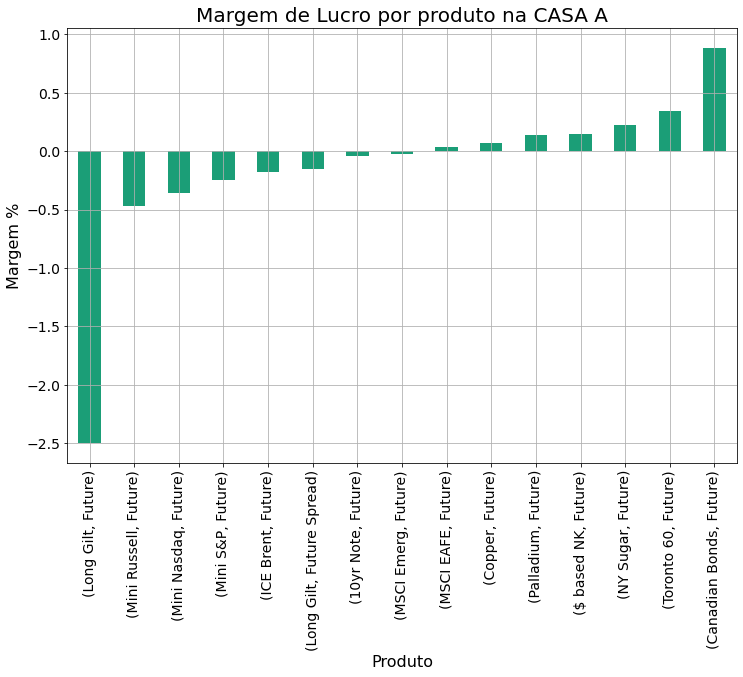

## CASA B

No broker CASA B, foram negociados 42 produtos a partir de 25535 operações.
Dentre as operações, 17957 foram de compra e 7578 de venda.




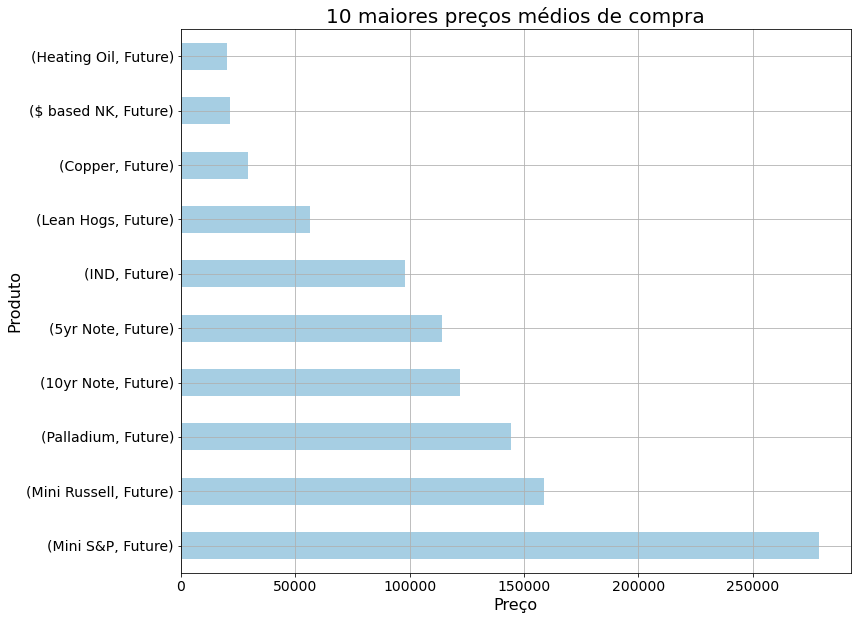

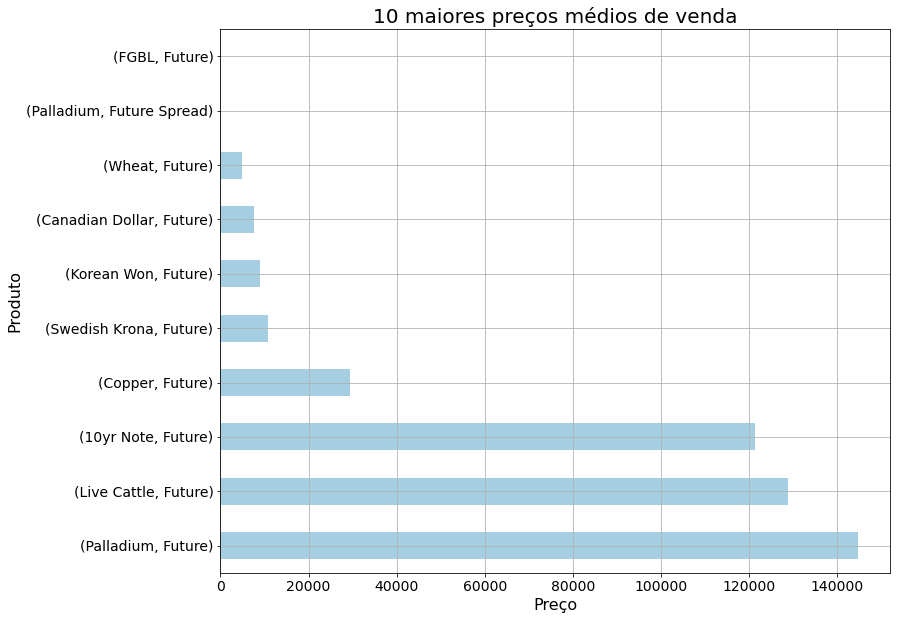

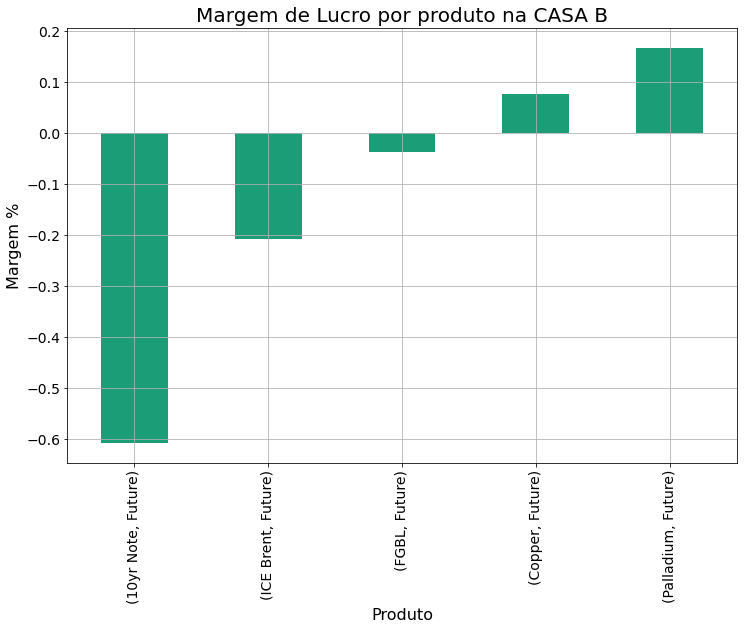

In [7]:
for broker in brokers:
    display(Markdown(f"## {broker}"))
    
    ##seleciona as operações do broker
    df_broker = df.loc[df['Broker'] == broker]
    precos = pivot_precos.loc[broker].copy()
    
    contagem = df_broker.groupby('Compra/Venda').count()

    print(f'No broker {broker}, foram negociados {precos.shape[0]} produtos a partir de {df_broker.shape[0]} operações.')
    print(f'Dentre as operações, {contagem.Qty.B} foram de compra e {contagem.Qty.S} de venda.')
    print('\n')
    
    top_10(precos, 'B', 'compra')
    top_10(precos,'S', 'venda')
    
    #gráfico indicando margem de lucro em ordem crescente
    fig = plt.figure(figsize = (12,8))
    pivot_lucro.loc[broker]['%N'].sort_values().plot(kind = 'bar', colormap = 'Dark2')
    plt.title(f"Margem de Lucro por produto na {broker}", fontsize = 20)
    plt.xlabel("Produto", fontsize = 16)
    plt.ylabel('Margem %', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(True)
    plt.show()
    
    print('\n')

## Comparação de preço médio de um ativo entre brokers

Valor positivo indica o quanto, em %, o preço médio de um ativo estava maior num broker em comparação com outro. Já um valor negativo indica um desconto de preço.

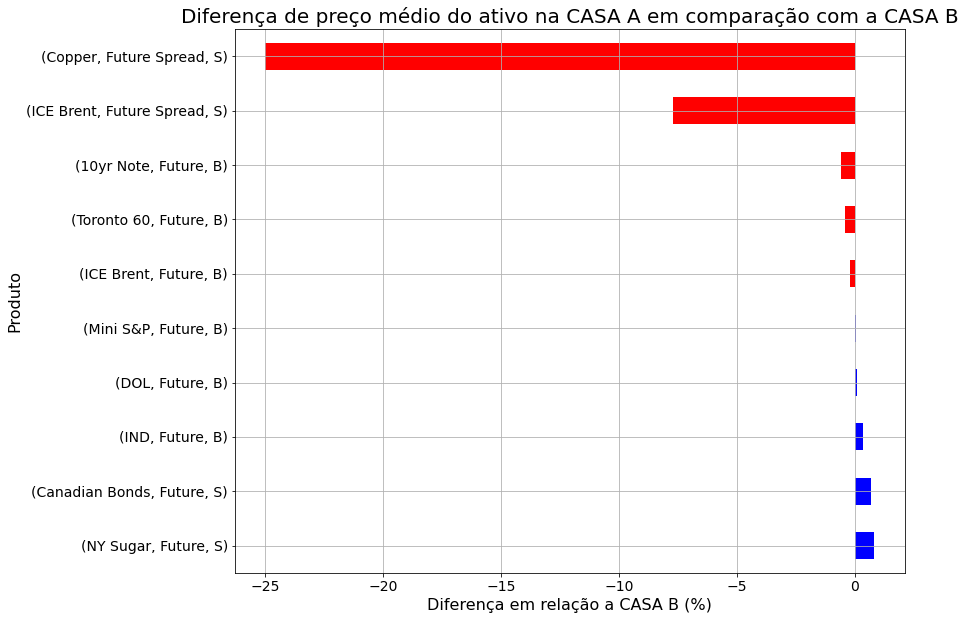

In [8]:
#criar pares de casas
pares = list(combinations(brokers, 2))

for par in pares:
    df1 = df.loc[df['Broker'] == par[0]]
    df2 = df.loc[df['Broker'] == par[1]] 
    
    #seleciona apenas os produtos em comum entre os dois brokers
    ativos = [p for p in list(df1.Produto.unique()) if p in list(df2.Produto.unique())]
    df_comum = df[df['Produto'].isin(ativos)]


    #cria uma pivot table 
    pivot_brokers = pd.pivot_table(df_comum, index = ['Produto', 'Product Type', 'Compra/Venda'], 
               columns = ['Broker'],
               aggfunc={'Custo':'sum', 'Qty': 'sum'})


    #retira operações que não tenham ocorrido em ambos os brokers 
    pivot_brokers.dropna(inplace = True)
    pivot_brokers['preço_medio', par[0]] = pivot_brokers.Custo[par[0]] / pivot_brokers.Qty[par[0]]
    pivot_brokers['preço_medio', par[1]] = pivot_brokers.Custo[par[1]] / pivot_brokers.Qty[par[1]]

    #calcula a diferença de preço médio do ativo em relação ao primeiro broker do par
    pivot_brokers['dif%'] = (pivot_brokers['preço_medio',par[0]] - pivot_brokers['preço_medio',par[1]]) * 100 / pivot_brokers['preço_medio',par[0]]
    
    #ordena a tabela em ordem descendente por dif%
    dif_ord = pivot_brokers.sort_values(by='dif%', ascending = False)['dif%']

    #seleciona os 5 maiores e 5 menores valores numa só tabela
    top_bottom_5 = pd.concat([dif_ord[:5], dif_ord[-5:]])

    #gera o gráfico
    fig = plt.figure(figsize = (12,10))

    top_bottom_5.plot(kind = 'barh',
                     color=(top_bottom_5 > 0).map({True: 'b', False: 'r'}))
    plt.title(f"Diferença de preço médio do ativo na {par[0]} em comparação com a {par[1]}", fontsize = 20)
    plt.xlabel(f"Diferença em relação a {par[1]} (%)", fontsize = 16)
    plt.ylabel('Produto', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(True)

    plt.show()

Segue em anexo a tabela de preços médio ponderado por ativos e lado da operação (compra ou venda) executados em cada Broker.

In [9]:
pivot_precos.to_csv('planilha_relatorio.csv')